In [35]:
# %pip install llama-index-multi-modal-llms-openai
# %pip install llama-index-vector-stores-qdrant

In [37]:
# %pip install llama_index ftfy regex tqdm
# %pip install git+https://github.com/openai/CLIP.git
# %pip install torch torchvision
# %pip install matplotlib scikit-image
# %pip install -U qdrant_client

In [38]:
import os

OPENAI_API_KEY = "sk"
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [39]:
from pathlib import Path

input_image_path = Path("input_images")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

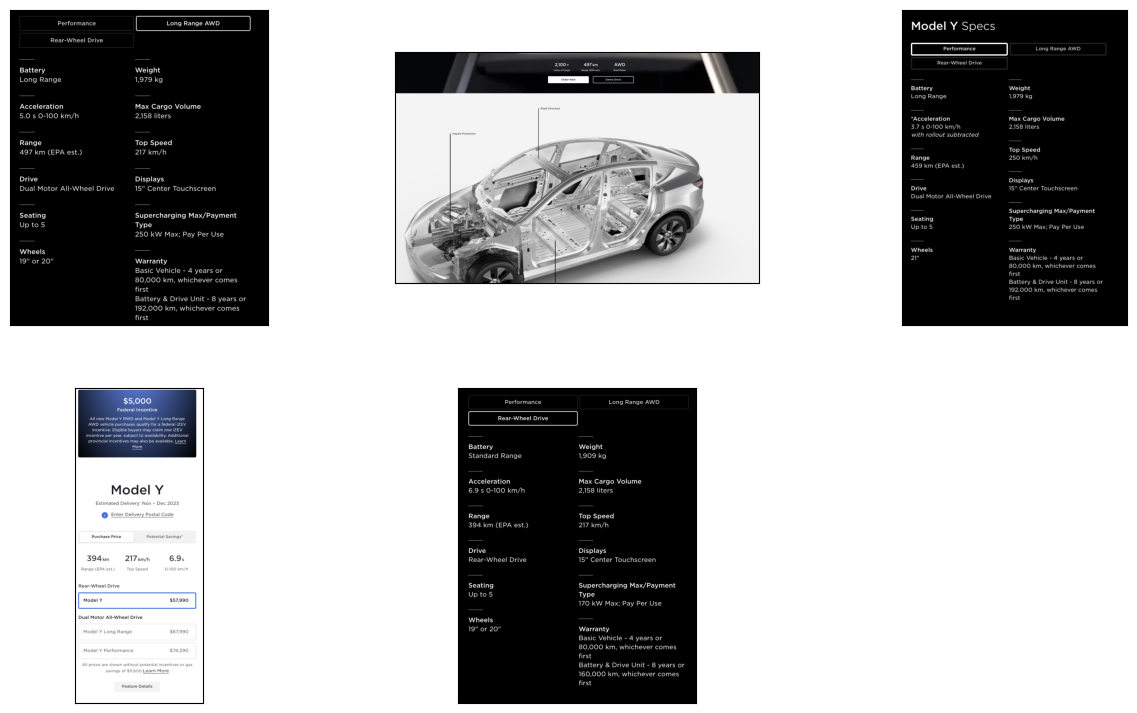

In [46]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./input_images"):
    image_paths.append(str(os.path.join("./input_images", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

In [48]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import SimpleDirectoryReader

# put your local directore here
image_documents = SimpleDirectoryReader("./input_images").load_data()

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", api_key=OPENAI_API_KEY, max_new_tokens=1500
)

response_1 = openai_mm_llm.complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

print(response_1)

1. **Image 1:**
   - **Title:** Performance, Rear-Wheel Drive, Long Range AWD
   - **Battery:** Long Range
   - **Weight:** 1,979 kg
   - **Acceleration:** 5.0 s 0-100 km/h
   - **Max Cargo Volume:** 2,158 liters
   - **Range:** 497 km (EPA est.)
   - **Top Speed:** 217 km/h
   - **Drive:** Dual Motor All-Wheel Drive
   - **Displays:** 15" Center Touchscreen
   - **Seating:** Up to 5
   - **Supercharging Max/Payment Type:** 250 kW Max; Pay Per Use
   - **Wheels:** 19" or 20"
   - **Warranty:** Basic Vehicle - 4 years or 80,000 km, whichever comes first; Battery & Drive Unit - 8 years or 192,000 km, whichever comes first

2. **Image 2:**
   - **Title:** Order Now, Demo Drive
   - **Top Section:** 2,100+ liters of Cargo, 497 km Range (EPA est.), AWD Dual Motor
   - **Main Image:** A semi-transparent view of a car showing its internal structure, labeled with "Rigid Structure" and "Impact Protection."

3. **Image 3:**
   - **Title:** Model Y Specs
   - **Battery:** Long Range
   - **Weight

In [49]:
response_2 = openai_mm_llm.complete(
    prompt="Can you tell me what is the price with each spec?",
    image_documents=image_documents,
)

print(response_2)

Based on the provided images, here are the prices for each specification of the Model Y:

1. **Model Y Rear-Wheel Drive:**
   - Price: $57,990
   - Battery: Standard Range
   - Weight: 1,909 kg
   - Acceleration: 6.9 s 0-100 km/h
   - Max Cargo Volume: 2,158 liters
   - Range: 394 km (EPA est.)
   - Top Speed: 217 km/h
   - Drive: Rear-Wheel Drive
   - Displays: 15" Center Touchscreen
   - Seating: Up to 5
   - Supercharging Max/Payment Type: 170 kW Max; Pay Per Use
   - Wheels: 19" or 20"
   - Warranty: Basic Vehicle - 4 years or 80,000 km, whichever comes first; Battery & Drive Unit - 8 years or 160,000 km, whichever comes first

2. **Model Y Long Range AWD:**
   - Price: $67,990
   - Battery: Long Range
   - Weight: 1,979 kg
   - Acceleration: 5.0 s 0-100 km/h
   - Max Cargo Volume: 2,158 liters
   - Range: 497 km (EPA est.)
   - Top Speed: 217 km/h
   - Drive: Dual Motor All-Wheel Drive
   - Displays: 15" Center Touchscreen
   - Seating: Up to 5
   - Supercharging Max/Payment Type:

In [50]:
import requests


def get_wikipedia_images(title):
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "imageinfo",
            "iiprop": "url|dimensions|mime",
            "generator": "images",
            "gimlimit": "50",
        },
    ).json()
    image_urls = []
    for page in response["query"]["pages"].values():
        if page["imageinfo"][0]["url"].endswith(".jpg") or page["imageinfo"][
            0
        ]["url"].endswith(".png"):
            image_urls.append(page["imageinfo"][0]["url"])
    return image_urls

In [55]:
from pathlib import Path
import requests
import urllib.request

image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 20

wiki_titles = {
    "Tesla Model Y",
    "Tesla Model X",
    "Tesla Model 3",
    "Tesla Model S",
    "Kia EV6",
    "BMW i3",
    "Audi e-tron",
    "Ford Mustang",
    "Porsche Taycan",
    "Rivian",
    "Polestar",
}


data_path = Path("mixed_wiki")
if not data_path.exists():
    Path.mkdir(data_path)

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    with open(data_path / f"{title}.txt", "w", encoding='utf-8') as fp:
        fp.write(wiki_text)

    images_per_wiki = 0
    try:
        # page_py = wikipedia.page(title)
        list_img_urls = get_wikipedia_images(title)
        # print(list_img_urls)

        for url in list_img_urls:
            if (
                url.endswith(".jpg")
                or url.endswith(".png")
                or url.endswith(".svg")
            ):
                image_uuid += 1
                # image_file_name = title + "_" + url.split("/")[-1]

                urllib.request.urlretrieve(
                    url, data_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue